# Abstract

In this project, we scraped 11k property rent listings from domain.com.au (~6k after preprocessing) and, combined with API queried POI data, tried to answer the 3 fundamental questions. We performed statistical tests on the scraped data combined with external data such as crime rate and income to determine relevant features to be used in our model. We used POI data as an insight into what makes certain properties valuable, but they provide no predictive value since their numbers do not fluctuate much over time.

We fit linear models to the dataset, and used correlation metrics to determine useful features. Unfortunately, only income was found to have any correlation with rent price, which resulted in our model not being very accurate. However, the model still was able to show us a general trend for the future, which still allowed us to answer the question of predictive growth.

For matters of livability, we used POI data and created a metric based on external reports of what Victorians consider to be signs that a place is livable. For affordability, we used income data and rent prices in each SA2 area to obtain an estimated percentage of salary to be paid for rent. From external reports, we found that most Australians are only willing to pay up to 30% of their salary on rent, and thus we reasoned that anything below that threshold for each SA2 area is considered to be affordable.

## Preliminary Code

In [7]:
# import packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt
import association_metrics as am

from itertools import chain
from numpy import arange
from statsmodels.formula.api import ols, glm
from statsmodels.api import families
from scipy.stats import chi2_contingency
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

# set directory
main_directory = os.getcwd().strip('notebooks')

## Property internal features analysis 

In this Section we will be examining the correlation of property internal features, such as property type, number of beds/baths/parking to the rental price of the properties. Relevant features will be selected for modelling in the next stage

In [6]:
# read in cleaned rental properties
rental_data_raw =pd.read_csv(main_directory+'data/curated/rental_properties_cleaned.csv')
# only want residential properties
rental_data_raw = rental_data_raw[(rental_data_raw['property_type'] != 'storage unit') &(rental_data_raw['property_type'] != 'Carspace')]
# drop irrelevant columns
rental_data = rental_data_raw.copy()
rental_data.drop(columns = ['Unnamed: 0.1', 'name'], inplace = True)
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')
# examine the correlation between the internal attributes of rental property; numerical

corr = rental_data.corr()
corr.style.background_gradient(cmap='coolwarm')


,index,cost_text,beds,baths,parking,under 20 (%),20 - 39 (%),40 - 59 (%),60 +(%)
index,1.000000,0.024692,0.002815,-0.001664,-0.001990,-0.012109,0.005622,-0.001649,0.001671
cost_text,0.024692,1.000000,0.320863,0.424150,0.166420,-0.069596,-0.015882,0.047522,0.054644
beds,0.002815,0.320863,1.000000,0.555679,0.498012,0.437816,-0.392116,0.167035,0.189110
baths,-0.001664,0.424150,0.555679,1.000000,0.348175,0.212736,-0.135217,0.073144,0.011129
parking,-0.001990,0.166420,0.498012,0.348175,1.000000,0.345164,-0.354583,0.194312,0.186673
under 20 (%),-0.012109,-0.069596,0.437816,0.212736,0.345164,1.000000,-0.687136,0.488667,0.051793
20 - 39 (%),0.005622,-0.015882,-0.392116,-0.135217,-0.354583,-0.687136,1.000000,-0.629799,-0.699556
40 - 59 (%),-0.001649,0.047522,0.167035,0.073144,0.194312,0.488667,-0.629799,1.000000,0.099178
60 +(%),0.001671,0.054644,0.189110,0.011129,0.186673,0.051793,-0.699556,0.099178,1.000000


In [8]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

Many of the features appear to be highly correlated with one another and not correlated with the response variable, so we dropped all of these.

(Maybe add something here)

In [9]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
cfit

,share_flag,property_type
share_flag,1.00,0.06
property_type,0.06,1.00


OLS Regression Summary:
                             OLS Regression Results                            
Dep. Variable:              cost_text   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     128.7
Date:                Mon, 10 Oct 2022   Prob (F-statistic):          5.41e-290
Time:                        03:22:15   Log-Likelihood:                -45628.
No. Observations:                6583   AIC:                         9.128e+04
Df Residuals:                    6570   BIC:                         9.137e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

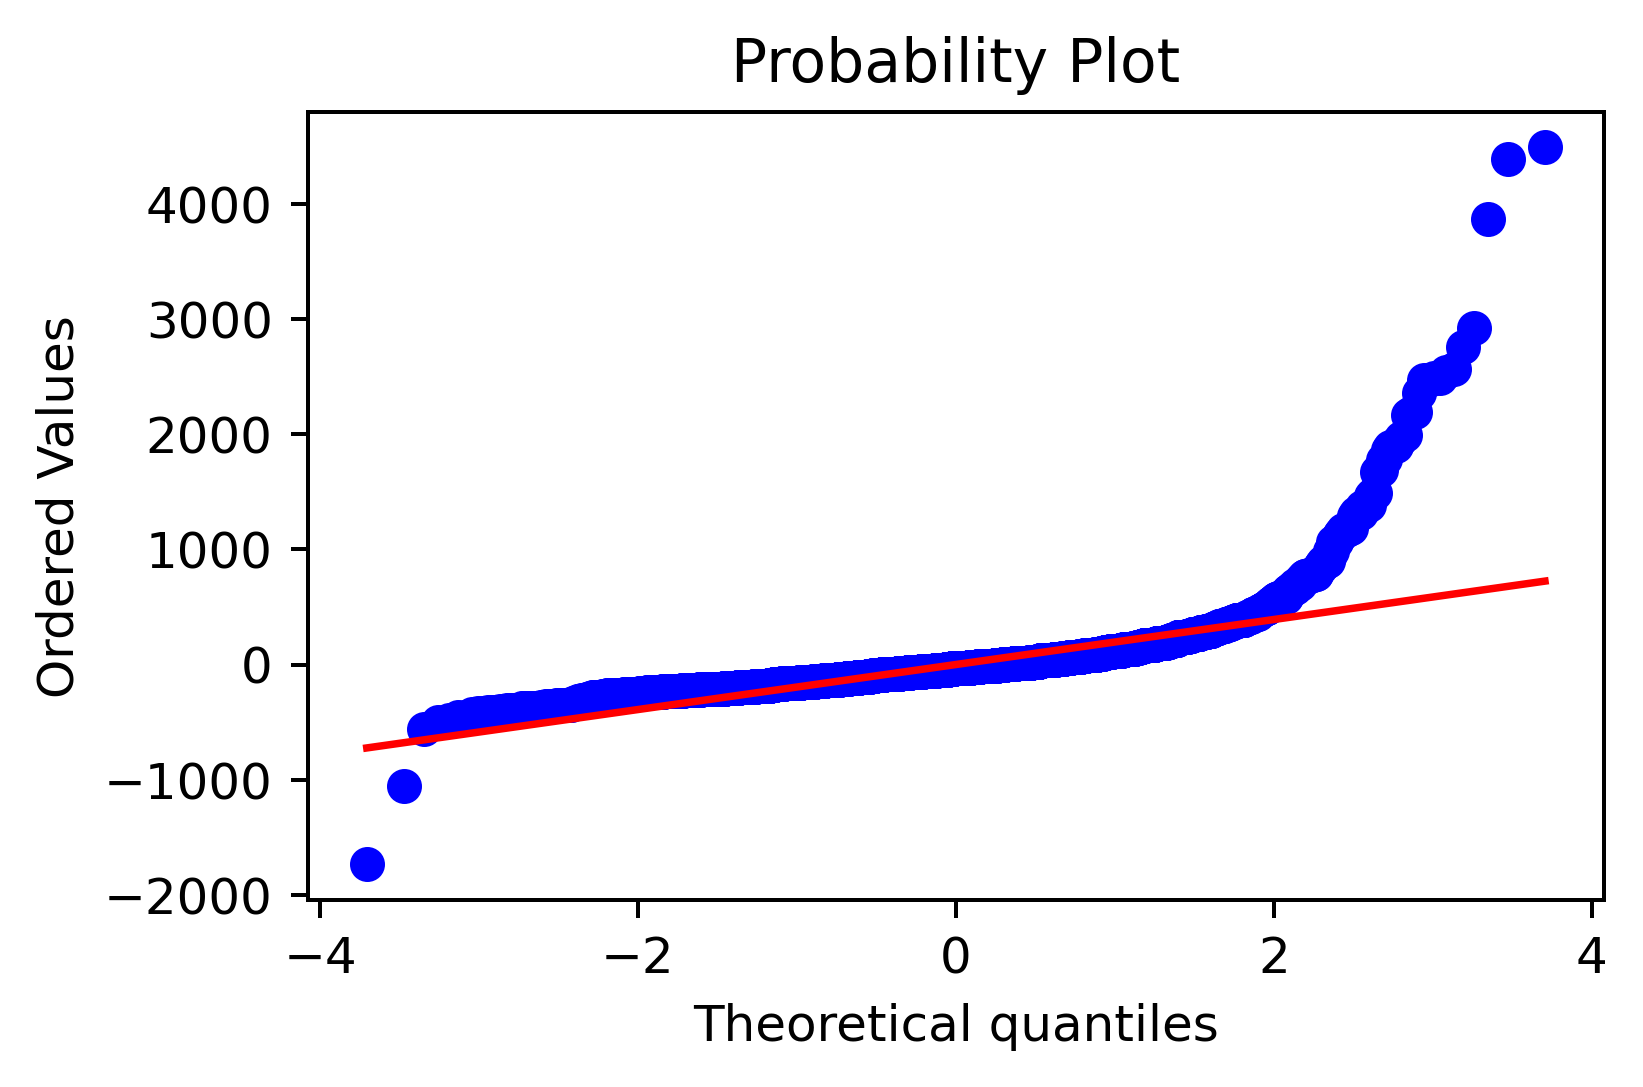

                 Generalized Linear Model Regression Results                  
Dep. Variable:              cost_text   No. Observations:                 6583
Model:                            GLM   Df Residuals:                     6570
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47453.
Date:                Mon, 10 Oct 2022   Deviance:                       760.94
Time:                        03:22:16   Pearson chi2:                 1.15e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04573
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [24]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

# check the fit of the model
print('OLS Regression Summary:\n', fit_OLS.summary())

# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)
plt.savefig('../plots/ptobplot.png')
plt.show()

# residuals show heavy tails, perhaps a negative binomial model is more suitable?
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()

print(fit_NB.summary())

In [27]:
# perform an anova on the linear regression model
anova_table = sm.stats.anova_lm(fit_OLS)

anova_table

,df,sum_sq,mean_sq,F,PR(>F)
share_flag,1.0,1.300651e+06,1.300651e+06,21.158082,4.308443e-06
property_type,10.0,1.296873e+07,1.296873e+06,21.096616,3.845590e-39
baths,1.0,8.065802e+07,8.065802e+07,1312.087931,4.147619e-262
Residual,6570.0,4.038778e+08,6.147303e+04,NaN,NaN


This section's analysis and modelling results suggest that the number of baths, property type and whether the property is shared or not is significant to the rental prices of the property. However, it appears that the variables are too simplistic on their own as predictors. Hence we will explore other external factors but retain these three features for our final modelling

## SA2 specific features analysis

In [32]:
# read in all SA2 specific features
SA2_features_raw = pd.read_csv(main_directory+'data/curated/external_features(SA2).csv')

# replace string values
SA2_features_raw = SA2_features_raw.replace(['np'],'0')

# drop na values
SA2_features_raw.dropna(inplace = True)

# make a copy to look at numerical values
SA2_features = SA2_features_raw.copy()
# drop irrelevant columns
SA2_features.drop(columns = ['pop_2021', 'Unnamed: 0','property_type','LGA code','SA2 code','SA2 name'], inplace = True)

# convert all columns to numerical 
for column in SA2_features.columns:
    # print(column)
    SA2_features[column]=SA2_features[column].astype(float)
    
# examine the correlation between the internal attributes of rental property; numerical
corr_2 = SA2_features .corr()
corr_2.style.background_gradient(cmap='coolwarm')

,cost_text,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
cost_text,1.000000,-0.053244,-0.098241,-0.058956,-0.033446,0.023290,-0.032278,0.094645,0.217546,0.285389
Area,-0.053244,1.000000,-0.066948,-0.143209,-0.179730,0.018418,-0.122788,-0.051292,-0.149585,-0.117593
Children_population,-0.098241,-0.066948,1.000000,0.461968,0.612009,0.513033,0.763762,-0.449693,-0.075987,-0.191118
Early_Working_age_population,-0.058956,-0.143209,0.461968,1.000000,0.666602,0.358664,0.719141,0.073924,-0.263296,-0.115203
Prime_Working_age_population,-0.033446,-0.179730,0.612009,0.666602,1.000000,0.377268,0.841241,-0.011264,0.090947,-0.020748
Mature_Working_age_population,0.023290,0.018418,0.513033,0.358664,0.377268,1.000000,0.768916,-0.404294,-0.193024,-0.076746
Elderly_population,-0.032278,-0.122788,0.763762,0.719141,0.841241,0.768916,1.000000,-0.269660,-0.107876,-0.085617
2021 crime rate,0.094645,-0.051292,-0.449693,0.073924,-0.011264,-0.404294,-0.269660,1.000000,0.132043,0.209057
Median $ 2019,0.217546,-0.149585,-0.075987,-0.263296,0.090947,-0.193024,-0.107876,0.132043,1.000000,0.838754
Mean $ 2019,0.285389,-0.117593,-0.191118,-0.115203,-0.020748,-0.076746,-0.085617,0.209057,0.838754,1.000000


Disappointingly, only mean income seem to be moderately correlated with rental prices, so we will only keep this feature for the final modelling. We will now examine how the SA2 featuers are correlated when it comes to mean and median SA2 rental prices.

In [34]:
mean_price = SA2_features_raw.groupby('SA2 name')['cost_text'].mean()
median_price = SA2_features_raw.groupby('SA2 name')['cost_text'].median()

# create a new dataframe to get SA2 specific features only
SA2_data = pd.DataFrame()
SA2_data['mean price'] = mean_price
SA2_data['median price']=median_price 

# iterate through dataframe and get SA2 features
for column in SA2_features_raw.iloc[[],8:]: 
    # convert to float
    SA2_features_raw[column] = SA2_features_raw[column].astype(float)
    # get SA2 features
    SA2_data = SA2_data.merge(SA2_features_raw.groupby('SA2 name')[column].first(),how='left', left_index=True, right_index=True)

SA2_features_raw.drop(columns='Unnamed: 0', inplace=True)
SA2_features_raw

,cost_text,property_type,LGA code,SA2 code,SA2 name,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
0,460.0,House,Ballarat,201011001,Alfredton,16823,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
1,440.0,House,Ballarat,201011001,Alfredton,16823,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
2,430.0,House,Ballarat,201011001,Alfredton,16823,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
3,460.0,House,Ballarat,201011001,Alfredton,16823,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
4,440.0,House,Ballarat,201011001,Alfredton,16823,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,600.0,House,Moyne,217041480,Warrnambool - South,13292,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,47242.0,58247.0
6642,212.0,Studio,Moyne,217041480,Warrnambool - South,13292,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,47242.0,58247.0
6643,390.0,House,Moyne,217041480,Warrnambool - South,13292,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,47242.0,58247.0
6644,380.0,House,Moyne,217041480,Warrnambool - South,13292,120.2,2064.0,1386.0,5817.0,1798.0,15519.0,0.029437,47242.0,58247.0


In [35]:
# plot correlation matrixes
# examine the correlation between the internal attributes of rental property; numerical
corr_3 = SA2_data.corr()
corr_3.style.background_gradient(cmap='coolwarm')

,mean price,median price,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
mean price,1.000000,0.910797,-0.067321,-0.005985,0.006502,0.070761,0.021910,0.038562,0.414635,0.550382
median price,0.910797,1.000000,-0.057036,-0.022896,-0.021859,0.041651,-0.005418,-0.043406,0.351651,0.448285
Children_population,-0.067321,-0.057036,1.000000,0.776332,0.847534,0.594543,0.865828,-0.240087,0.102760,-0.045456
Early_Working_age_population,-0.005985,-0.022896,0.776332,1.000000,0.866628,0.612759,0.878974,-0.015631,0.065417,0.060770
Prime_Working_age_population,0.006502,-0.021859,0.847534,0.866628,1.000000,0.605204,0.928216,-0.012844,0.213479,0.095924
Mature_Working_age_population,0.070761,0.041651,0.594543,0.612759,0.605204,1.000000,0.825209,-0.236848,-0.114298,-0.024309
Elderly_population,0.021910,-0.005418,0.865828,0.878974,0.928216,0.825209,1.000000,-0.137797,0.070241,0.043399
2021 crime rate,0.038562,-0.043406,-0.240087,-0.015631,-0.012844,-0.236848,-0.137797,1.000000,0.115220,0.160405
Median $ 2019,0.414635,0.351651,0.102760,0.065417,0.213479,-0.114298,0.070241,0.115220,1.000000,0.841154
Mean $ 2019,0.550382,0.448285,-0.045456,0.060770,0.095924,-0.024309,0.043399,0.160405,0.841154,1.000000


It looks like mean price is highly correlated with the mean SA2 rental prices, we will also potentially fit models with other moderately correlated variables